# Read the desired data from journaldb

In [1]:
import dotenv
import pendulum
from gjk.config import Settings
from gjk.models import ReadingSql
from sqlalchemy import create_engine, asc
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import SQLAlchemyError
from gjk.enums import TelemetryName
from gjk.first_season.beech_channels import BEECH_CHANNELS_BY_NAME
import pendulum
from typing import Dict, List
from gjk.models import ReadingSql
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

settings = Settings(_env_file=dotenv.find_dotenv())
engine = create_engine(settings.db_url.get_secret_value())
Session = sessionmaker(bind=engine)
session = Session()

timezone = "America/New_York"

# Shows IDU/ODU not matching
start = pendulum.datetime(2024, 2, 2, 0, 0, tz=timezone)
end = pendulum.datetime(2024, 2, 2, 23, 0, tz=timezone)

# Shows GPM not matching
start = pendulum.datetime(2024, 2, 3, 0, 0, tz=timezone)
end = pendulum.datetime(2024, 2, 3, 23, 0, tz=timezone)

start = pendulum.datetime(2024, 2, 3, 17, 0, tz=timezone)
end = pendulum.datetime(2024, 2, 3, 23, 0, tz=timezone)

start_ms = int(start.timestamp() * 1000)
end_ms = int(end.timestamp() * 1000)

In [2]:
ewt = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == 'cecc9b94-9b4b-45ce-a8e9-4c63d24530aa').order_by(asc(ReadingSql.time_ms)).all()

lwt = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == 'a49db047-e38f-44a4-b773-29102c2fc526').order_by(asc(ReadingSql.time_ms)).all()

mhp = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == '94c3ab5c-7dd1-43c5-9870-733930251396').order_by(asc(ReadingSql.time_ms)).all()

odu = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == '498da855-bac5-47e9-b83a-a11e56a50e67').order_by(asc(ReadingSql.time_ms)).all()

idu = session.query(ReadingSql).filter(
    ReadingSql.time_ms >= start_ms,
    ReadingSql.time_ms < end_ms,
    ReadingSql.data_channel_id == 'beabac86-7caa-4ab4-a50b-af1ad54ed165').order_by(asc(ReadingSql.time_ms)).all()

# 1 - Estimating heating power output

## 1.1 - EWT and LWT

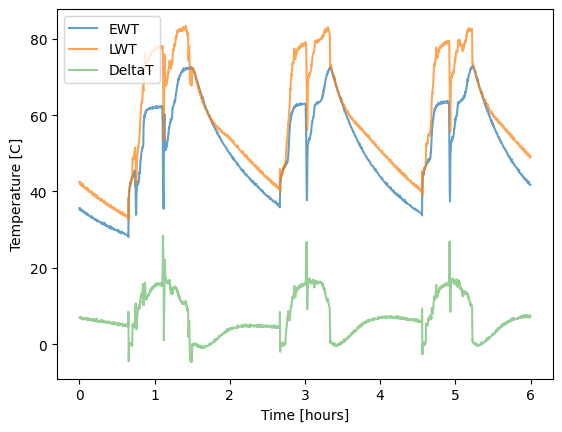

In [3]:
ewt_values = []
ewt_times = []
for e in ewt:
    if e.value > 0:
        ewt_values.append(e.value)
        ewt_times.append(e.time_ms)
ewt_times = [(x-ewt_times[0])/1000/60/60 for x in ewt_times]
ewt_values = [x/1000 for x in ewt_values]

lwt_values = []
lwt_times = []
for l in lwt:
    if l.value > 0:
        lwt_values.append(l.value)
        lwt_times.append(l.time_ms)
original_lwt_times = lwt_times
lwt_times = [(x-lwt_times[0])/1000/60/60 for x in lwt_times]
lwt_values = [x/1000 for x in lwt_values]

df_ewt = pd.DataFrame({'time': ewt_times, 'ewt': ewt_values})
df_lwt = pd.DataFrame({'time': lwt_times, 'lwt': lwt_values})
df_ewt = df_ewt.sort_values('time')
df_lwt = df_lwt.sort_values('time')

# Merge on time and compute delta_t
df_ewt_lwt = pd.merge_asof(df_lwt, df_ewt, on='time')
df_ewt_lwt['delta_t'] = df_ewt_lwt['lwt'] - df_ewt_lwt['ewt']

plt.plot(df_ewt_lwt.time, df_ewt_lwt.ewt, alpha=0.7, label='EWT')
plt.plot(df_ewt_lwt.time, df_ewt_lwt.lwt, alpha=0.7, label='LWT')
plt.plot(df_ewt_lwt.time, df_ewt_lwt.delta_t, alpha=0.5, label="DeltaT")
plt.xlabel('Time [hours]')
plt.ylabel('Temperature [C]')
plt.legend(loc='upper left')
#plt.xlim([7.8, 9.9])
plt.show()

## 1.2 - Flow rate

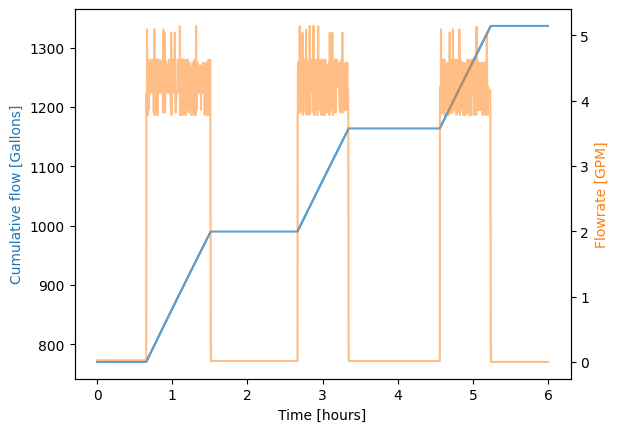

In [4]:
# Cumulative gallons
gallons_values = []
gallons_times = []
for m in mhp:
    gallons_values.append(m.value)
    gallons_times.append(m.time_ms)
gallons_times = [(x-gallons_times[0])/1000/60/60 for x in gallons_times]
gallons_values = [x/100 for x in gallons_values]
gallons_values = sorted(gallons_values)
gallons_times = sorted(gallons_times)

# Convert to gpm
flow_values = []
flow_times = []

gallons_now = gallons_values[0]
time_now = gallons_times[0]

for i in range(len(gallons_values)):

    if gallons_values[i] > gallons_now:

        gpm = (gallons_values[i]-gallons_now)/(60*(gallons_times[i]-time_now))
        flow_values.append(gpm)
        flow_times.append(time_now)

        gallons_now = gallons_values[i]
        time_now = gallons_times[i]

# If the last cumulative gallons is the same as the last update (no flow since last point)
if gallons_values[-1] == gallons_now:
    flow_values.append(0)
    flow_times.append(time_now)

df_flowrate = pd.DataFrame({'time':flow_times, 'flowrate':flow_values})
df_flowrate = df_flowrate.sort_values('time')
df_ewt_lwt = df_ewt_lwt.sort_values('time')

# Merge on time with temperature values
df_heatpower = pd.merge_asof(df_ewt_lwt, df_flowrate, on='time')

fig, ax = plt.subplots(1,1)
ax.plot(gallons_times, gallons_values, alpha=0.7)
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Cumulative flow [Gallons]', color='tab:blue')
ax2 = ax.twinx()
ax2.plot(df_heatpower.time, df_heatpower.flowrate, alpha=0.5, color='tab:orange')
ax2.set_ylabel('Flowrate [GPM]', color='tab:orange')
plt.show()

## 1.3 - Heating power ouput

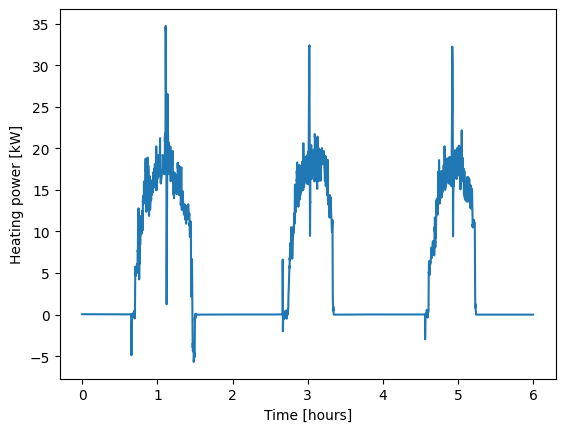

In [5]:
df_heatpower['Q_HP'] = (3.78541 * df_heatpower.flowrate / 60) * 4187 * df_heatpower.delta_t / 1000

plt.plot(df_heatpower.time, df_heatpower.Q_HP)
plt.xlabel('Time [hours]')
plt.ylabel('Heating power [kW]')
plt.show()

# 2 - Estimating electrical power input

Data length before resampling: 879, after resampling: 21478


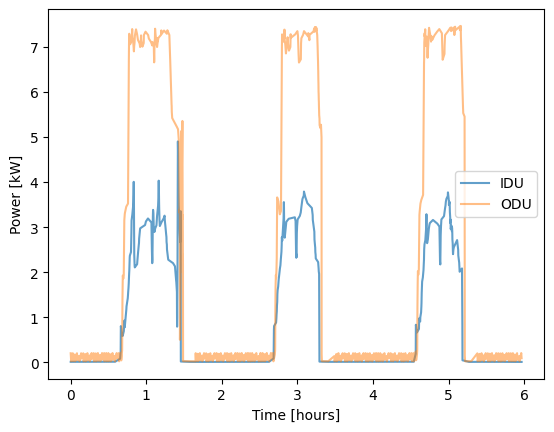

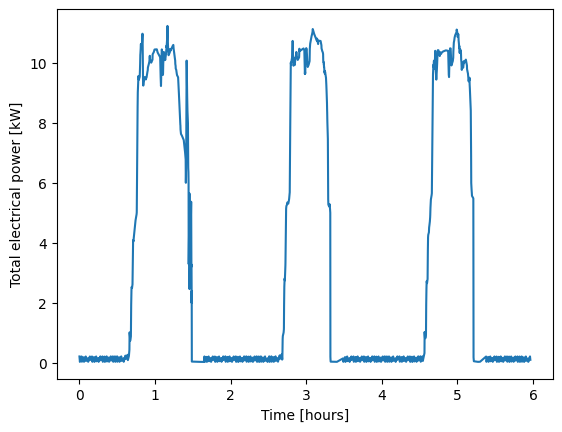

In [6]:
idu_values = []
idu_times = []
for x in idu:
    if x.value > 0:
        idu_values.append(x.value/1000)
        idu_times.append(x.time_ms)
idu_times = [(x-idu_times[0])/1000/60/60 for x in idu_times]

odu_values = []
odu_times = []
for x in odu:
    if x.value > 0:
        odu_values.append(x.value/1000)
        odu_times.append(x.time_ms)
odu_times = [(x-odu_times[0])/1000/60/60 for x in odu_times]

df_idu = pd.DataFrame({'time':idu_times, 'idu':idu_values})
df_odu = pd.DataFrame({'time':odu_times, 'odu':odu_values})
df_idu = df_idu.sort_values('time')
df_odu = df_odu.sort_values('time')

df_odu['time'] = pd.to_datetime(df_odu['time']*3600, unit='s')
df_idu['time'] = pd.to_datetime(df_idu['time']*3600, unit='s')
df_odu.set_index('time', inplace=True)
df_idu.set_index('time', inplace=True)

# Resample both DataFrames to a common frequency (e.g., 1 second)
df_odu_resampled = df_odu.resample('s').mean().interpolate()
df_idu_resampled = df_idu.resample('s').mean().interpolate()

# Merge using merge_asof on the resampled DataFrames
df_elecpower = pd.merge_asof(df_odu_resampled, df_idu_resampled, on='time', direction='backward')
df_elecpower['time'] = (df_elecpower['time'] - df_elecpower['time'].min()).dt.total_seconds() / 3600
df_elecpower['W_HP'] = df_elecpower.idu + df_elecpower.odu

print(f"Data length before resampling: {len(odu_times)}, after resampling: {len(df_elecpower)}")

plt.plot(df_elecpower.time, df_elecpower.idu, alpha=0.7, label='IDU')
plt.plot(df_elecpower.time, df_elecpower.odu, alpha=0.5, label='ODU')
plt.xlabel('Time [hours]')
plt.ylabel('Power [kW]')
plt.legend()
plt.show()

plt.plot(df_elecpower.time, df_elecpower.W_HP)
plt.xlabel('Time [hours]')
plt.ylabel('Total electrical power [kW]')
plt.show()

# 3 - Estimating COP

,time,lwt,ewt,delta_t,flowrate,Q_HP,odu,idu,W_HP,COP
0,0.00,42.52,35.62,6.90,0.03,46.88,0.20,0.01,218.00,0.22
1,0.00,42.22,35.35,6.86,0.03,46.64,0.20,0.01,218.00,0.21
2,0.01,41.96,35.10,6.87,0.03,46.64,0.04,0.01,53.19,0.88
3,0.01,42.26,35.18,7.08,0.03,48.10,0.04,0.01,57.24,0.84
4,0.01,41.97,35.18,6.78,0.03,46.08,0.05,0.01,59.27,0.78
...,...,...,...,...,...,...,...,...,...,...
3138,5.98,49.68,42.18,7.50,0.00,0.00,0.09,0.01,106.00,0.00
3139,5.98,49.19,42.18,7.01,0.00,0.00,0.09,0.01,106.00,0.00
3140,5.99,48.94,41.74,7.20,0.00,0.00,0.09,0.01,106.00,0.00
3141,6.00,49.21,41.71,7.51,0.00,0.00,0.09,0.01,106.00,0.00


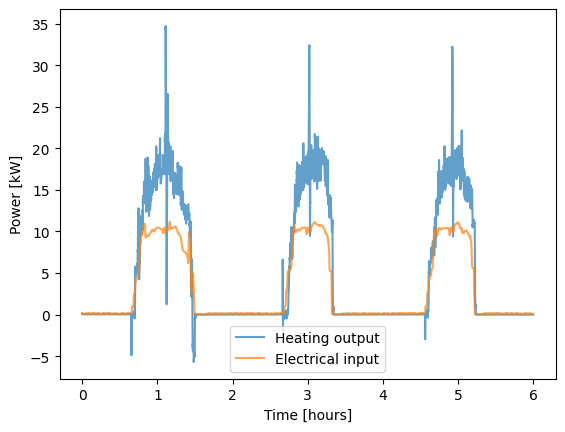

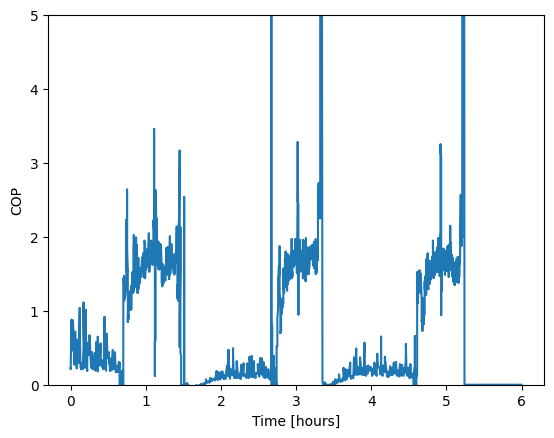

In [7]:
# Merge elec power and heating power
final = pd.merge_asof(df_heatpower, df_elecpower, on='time')
final['COP'] = final.Q_HP/final.W_HP

plt.plot(final.time, final.Q_HP, alpha=0.7, label='Heating output')
plt.plot(final.time, final.W_HP, alpha=0.7, label='Electrical input')
plt.xlabel('Time [hours]')
plt.ylabel('Power [kW]')
plt.legend()

final.Q_HP = final.Q_HP * 1000
final.W_HP = final.W_HP * 1000
final = final.round(2)
display(final)
plt.show()

plt.plot(final.time, final.COP)
plt.xlabel('Time [hours]')
plt.ylabel('COP')
plt.ylim([0,5])
plt.show()